In [1]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess data
df = pd.read_csv("/Users/preiranameruga/Downloads/Sunspots.csv", index_col=0)
monthly_means = torch.tensor(df['Monthly Mean Total Sunspot Number'].values, dtype=torch.float32)
num_train=1000
num_test=200
mean = monthly_means.mean()
std = monthly_means.std()
monthly_means = (monthly_means - mean) / std
train=(monthly_means[:5]).reshape(1,5,1)
out=monthly_means[5:num_train+5].reshape(-1,1,1)
for i in range(1,num_train):
    train=torch.cat((train,(monthly_means[i:i+5]).reshape(1,5,1)), dim=0)

# Prepare training and testing data
trainset = TensorDataset(train, out)
train_dataloader = DataLoader(trainset, batch_size=1, shuffle=True)
'''monthly_means = monthly_means.reshape(-1, 5, 1)
test = monthly_means[num_train//5:num_test+num_train//5, :, :]
expected = monthly_means[num_train//5+1:num_train//5+num_test+1, 0, :].reshape(-1, 1, 1)'''

# Define the LSTM model
class myLSTM(nn.Module):
    def __init__(self):
        super(myLSTM, self).__init__()
        self.input_dim = 1
        self.hidden_dim = 10
        self.layer_dim = 5
        self.output_dim = 1
        self.rnn = nn.LSTM(self.input_dim, self.hidden_dim, num_layers=self.layer_dim, batch_first=True, dropout=0.3)
        self.lin_transf = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        output, (hn, cn) = self.rnn(x, (h0, c0))
        output = (self.lin_transf(output[:, -1, :])).reshape(-1,1,1)
        return output

model = myLSTM()
lrate = 0.001
optim = torch.optim.Adam(model.parameters(), lr=lrate)
error = nn.MSELoss()

# Training loop function
def train_loop(dataloader, lstm_model, loss_fn, optimizer):
    lstm_model.train()
    for batch, (X, y) in enumerate(dataloader):
        optimizer.zero_grad()
        pred = lstm_model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        if batch % 500 == 0:
            print(f"Batch {batch}, Loss: {loss.item()}")

# Training the model
epochs = 15000
for epoch in range(epochs):
    if (epoch+1)%1000==0:
        print(f"Epoch {epoch+1}\n-------------------------------")
        train_loop(train_dataloader, model, error, optim)

def calculate_accuracy(pred, y, tolerance):
    correct = torch.abs(pred - y) <= tolerance
    accuracy = correct.sum().item() / len(correct)
    return accuracy

# Test loop function
def test_loop(X, y, lstm_model, loss_fn):
    lstm_model.eval()
    with torch.no_grad():
        pred = lstm_model(X)
        loss = loss_fn(pred, y)
        accuracy = calculate_accuracy(pred, y, 10)
        print(accuracy)
        print(f"Test Loss: {loss.item()}")
        # Inverse transform the predictions and expected values
        pred_original = pred * std + mean
        expected_original = y * std + mean

        # Print some of the original values for manual checking
        print(f"Predictions (original scale): {pred_original.squeeze()[:5]}")
        print(f"Expected (original scale): {expected_original.squeeze()[:5]}")
        return(pred_original, expected_original)


(y,x)=test_loop(train, out, model, error)


Epoch 1000
-------------------------------
Batch 0, Loss: 0.0964265689253807
Batch 500, Loss: 0.141187846660614
Epoch 2000
-------------------------------
Batch 0, Loss: 0.027460485696792603
Batch 500, Loss: 0.1055084839463234
Epoch 3000
-------------------------------
Batch 0, Loss: 0.036033596843481064
Batch 500, Loss: 0.01779952645301819
Epoch 4000
-------------------------------
Batch 0, Loss: 0.016603270545601845
Batch 500, Loss: 0.11737450957298279
Epoch 5000
-------------------------------
Batch 0, Loss: 0.2560332715511322
Batch 500, Loss: 0.35642147064208984
Epoch 6000
-------------------------------
Batch 0, Loss: 0.06992069631814957
Batch 500, Loss: 0.10976096987724304
Epoch 7000
-------------------------------
Batch 0, Loss: 0.0006931195384822786
Batch 500, Loss: 0.07707294076681137
Epoch 8000
-------------------------------
Batch 0, Loss: 0.007872501388192177
Batch 500, Loss: 0.020140407606959343
Epoch 9000
-------------------------------
Batch 0, Loss: 0.19859641790390015


KeyboardInterrupt: 

In [2]:
num_test=200
monthly_means = torch.tensor(df['Monthly Mean Total Sunspot Number'].values, dtype=torch.float32)
monthly_means = (monthly_means - mean) / std
monthly_means = monthly_means [num_train-5:]
test = monthly_means[:5].reshape(1,5,1)
for i in range(1,num_test):
    test = torch.cat((test, monthly_means[i:i+5].reshape(1,5,1)), dim=0)
expected = monthly_means[5:num_test+5].reshape(-1,1,1)

In [3]:
(simple,x)=test_loop(test, expected, model, error)

1.0
Test Loss: 0.2835518419742584
Predictions (original scale): tensor([63.4194, 69.3785, 54.6215, 34.8882, 20.7573])
Expected (original scale): tensor([68.9000, 44.5000, 23.3000, 14.8000, 13.7000])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


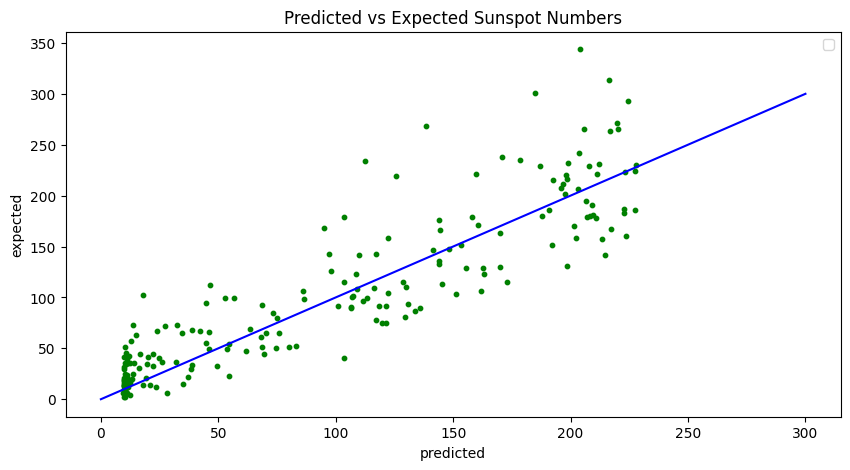

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.scatter(simple.reshape(x.shape[0]), x.reshape(x.shape[0]), s=10, color='g')
import numpy as np
x0 = np.linspace(0, 300, 10)
y0=x0
plt.plot(x0,y0, color='b')
plt.legend()
plt.title('Predicted vs Expected Sunspot Numbers')
plt.xlabel('predicted')
plt.ylabel('expected')
plt.show()


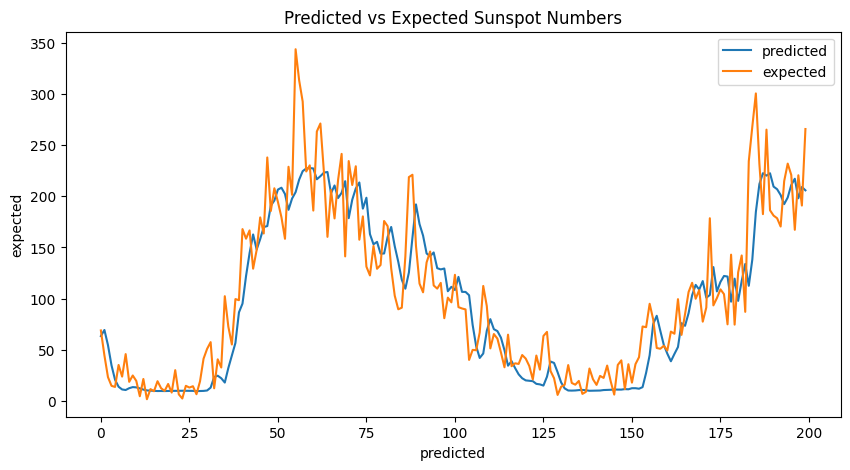

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(simple.reshape(x.shape[0])[:200], label='predicted')
plt.plot( x.reshape(x.shape[0])[:200], label='expected')
plt.legend()
plt.title('Predicted vs Expected Sunspot Numbers')
plt.xlabel('predicted')
plt.ylabel('expected')
plt.show()

In [6]:
num_test=200
monthly_means = torch.tensor(df['Monthly Mean Total Sunspot Number'].values, dtype=torch.float32)
monthly_means = (monthly_means - mean) / std
monthly_means = monthly_means[num_train-4:]
x = monthly_means[:5].reshape(-1,5,1)
pred = x
y = model(x)
pred = torch.cat((pred, y.reshape(1,1,1)), dim=1)
for i in range(1,num_test):
    x = pred[:,i:i+5,:]
    y = model(x)
    pred = torch.cat((pred, y.reshape(1,1,1)), dim=1)
pred = std*pred + mean
monthly_means = std*monthly_means + mean
pred = pred[:,:-5,:]

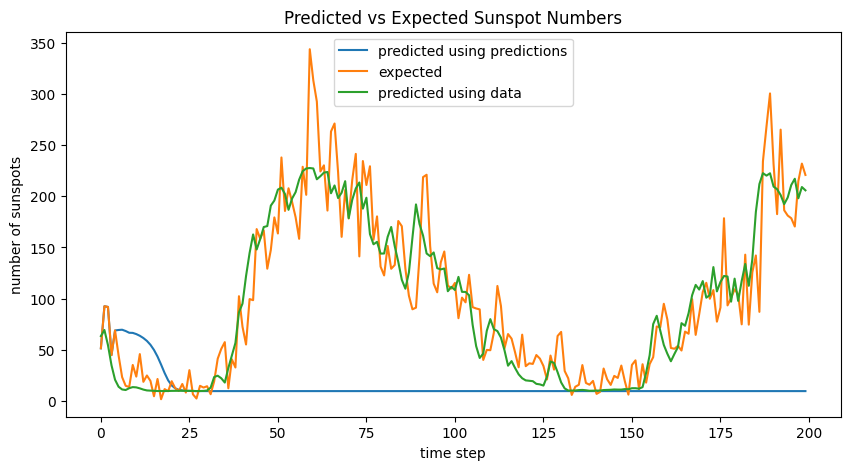

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(pred.reshape(pred.size(1)).detach(), label='predicted using predictions')
plt.plot(monthly_means[:pred.size(1)], label='expected')
plt.plot(simple.reshape(200).detach(), label='predicted using data')
plt.plot()
plt.legend()
plt.title('Predicted vs Expected Sunspot Numbers')
plt.xlabel('time step')
plt.ylabel('number of sunspots')
plt.show()